## Data Driven Modelling HOMEWORK 4
### SUBMITTED BY KARTIK VIRMANI 30894143
### Refrences :
##### 1)Probabilistic Machine Learning Kevin P Murphy;
##### 2)https://jax.readthedocs.io/en/latest/quickstart.html (Python Jax Documentation);
##### 3)FLAX_CNN / RNN_INTRO / MLP_INTRO as provided by Prof. Paris P
### File Prepared in Microsoft Visual Studio using Jupytr Notebook

### Problem 1 (20 pts):

Train a convolutional neural network on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The network architecture should be as follows:

- Input layer: Accepts 32x32x3 images
- Convolution layer: 6 filters, filter size 5x5x3, stride 1
- ReLU layer: Accepts and returns a 32x32x6 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 12 filters, filter size 5x5x6, stride 1
- ReLU layer: Accepts and returns a 16x16x12 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 24 filters, filter size 5x5x12, stride 1
- ReLU layer: Accepts and returns a 8x8x24 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Fully connected network with 2 hidden layers: Accepts a flattened tensor of dimension 4x4x24 and outputs a 10-dimensional tensor containing the predicted class labels. The layer dimensions should be [384,120,84,10].

Notice how in each layer the number of filters is doubled, while the feature resolution is halved (_hint: make sure you use the appropriate amount of padding to achieve this_). Use the multi-class cross entropy loss function and the Adam optimizer with a learning rate of $10^{-3}$. Train the network for a total of 20000 iterations using a batch size of 128 images. Report the loss as a function of the training iterations, and the resulting confusion matrix for the test data-set. What do you notice here? Propose changes to improve the accuracy over the test set, and verify that you see an improvement of atleast 5% with your changes.

In [ ]:
!pip install --upgrade flax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.3/419.3 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.8.5
    Uninstalling flax-0.8.5:
      Successfully uninstalled flax-0.8.5


In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random, vmap, grad, jit
from jax.nn import one_hot

import flax.linen as nn
import optax
from sklearn.metrics import confusion_matrix

from typing import Any, Callable, Sequence, Optional, Union, Dict

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
# Some helper functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5,4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)
          plt.imshow(conv[0,:,:,cnt])
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [ ]:
class ConvNet(nn.Module):
    out_channels: Sequence[int]
    layer : Sequence [int]
    out_dim: int = 10
    activation: Callable=nn.relu

    @nn.compact
    def __call__(self, x):
        for i in range(len(self.out_channels)):
            x = nn.Conv(self.out_channels[i],  kernel_size=(5,5), strides=(1,1), padding="SAME")(x)
            x = self.activation(x)
            x = nn.max_pool(x, (2,2), (2,2))

        x = x.flatten()
        for dim in self.layer:
            x = nn.Dense(dim)(x)
            x = self.activation(x)
        x = nn.Dense(self.out_dim)(x.flatten())
        return nn.softmax(x)

In [ ]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, arch, rng_key=random.PRNGKey(0)):

        # Initialization and evaluation functions
        inputs = jnp.ones((1,32,32,3))
        self.model = arch
        self.params = self.model.init(rng_key, inputs)
        print(self.model.tabulate(rng_key, inputs))
        self.apply = vmap(self.model.apply, in_axes=(None,0))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.chain(optax.clip_by_global_norm(1.0),  # Clip gradients with norm > 1.0
                                     optax.adam(learning_rate=lr))
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch, epsilon=1e-8):
        images, labels = batch
        outputs = self.apply(params, images)
        loss = -labels*jnp.log(outputs + epsilon)
        return jnp.mean(loss)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

In [ ]:
import torchvision as tv

# Training data
train = tv.datasets.CIFAR10('./', download=True, train=True)
train_images = jnp.array(train.data)
train_labels = jnp.array(train.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
train_images = train_images[:,:,:]/255.

num_classes = train_labels.max()+1
train_labels = one_hot(train_labels, num_classes)

100%|██████████| 170M/170M [00:04<00:00, 37.8MB/s]


Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
from torch.utils import data

class DataGenerator(data.Dataset):
    def __init__(self, images, labels,
                 batch_size=128,
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128)
data = iter(train_dataset)
batch = next(data)

In [ ]:
inputs, targets = batch
print(inputs.shape)

(128, 32, 32, 3)


In [ ]:
# Initialize model
arch1 = ConvNet(out_channels=(6, 12, 24), layer = (384,120,84),
               out_dim=num_classes,
               activation=nn.relu)
model1 = CNNclassifier(arch1)

arch2 = ConvNet(out_channels=(32, 64, 128, 256), layer = (384,120,84),
               out_dim=num_classes,
               activation=nn.relu)
model2 = CNNclassifier(arch2)


                                       ConvNet Summary                                       
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs             ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ ConvNet │ float32[1,32,32,3] │ float32[10]         │                            │
├─────────┼─────────┼────────────────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ Conv    │ float32[1,32,32,3] │ float32[1,32,32,6]  │ bias: float32[6]           │
│         │         │                    │                     │ kernel: float32[5,5,3,6]   │
│         │         │                    │                     │                            │
│         │         │                    │                     │ 456 (1.8 KB)               │
├─────────┼─────────┼────────────────────┼─────────────────

100%|██████████| 20000/20000 [00:55<00:00, 361.76it/s, loss=0.00038330394]


Text(0, 0.5, 'Loss')

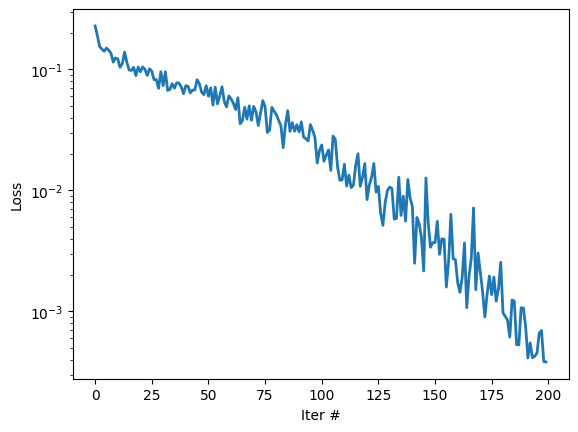

In [ ]:
# Train model1
model1.train(train_dataset, nIter=20000)

# Plot loss
plt.figure()
plt.plot(model1.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

100%|██████████| 20000/20000 [03:12<00:00, 104.11it/s, loss=8.332427e-06]


Text(0, 0.5, 'Loss')

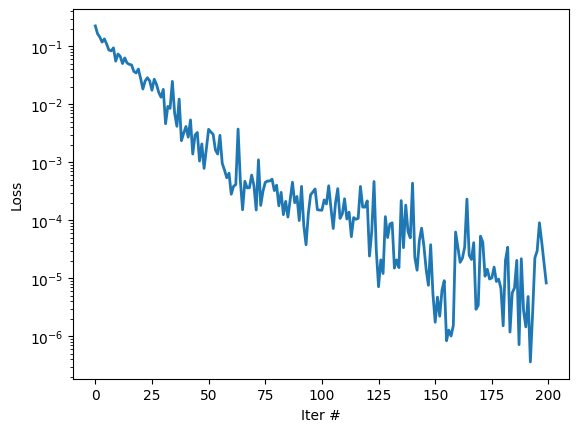

In [ ]:
# Train model2
model2.train(train_dataset, nIter=20000)

# Plot loss
plt.figure()
plt.plot(model2.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
# Test data
test = tv.datasets.CIFAR10('./', download=True, train=False)
test_images = jnp.array(test.data)
test_labels = jnp.array(test.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

Files already downloaded and verified


In [ ]:
# Compute classification accuracy on the entire test data-set
@jit
def accuracy1(params, batch):
    images, labels = batch
    outputs = model1.apply(params, images)
    pred_class = jnp.argmax(outputs,1)
    true_class = jnp.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

@jit
def accuracy2(params, batch):
    images, labels = batch
    outputs = model2.apply(params, images)
    pred_class = jnp.argmax(outputs,1)
    true_class = jnp.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc1 = accuracy1(model1.params, (test_images, test_labels))
acc2 = accuracy2(model2.params, (test_images, test_labels))
print('Classification accuracy MODEL 1: {}%'.format(100*acc1))
print('Classification accuracy MODEL 2: {}%'.format(100*acc2))

Classification accuracy MODEL 1: 64.58000183105469%
Classification accuracy MODEL 2: 73.15999603271484%


MODEL 1 : 64.58000183105469%
MODEL 2 : 73.15999603271484%


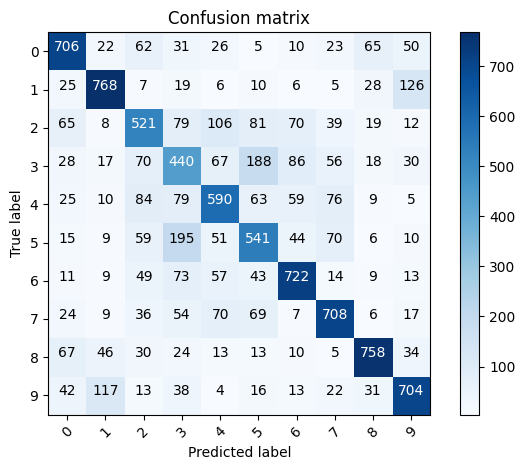

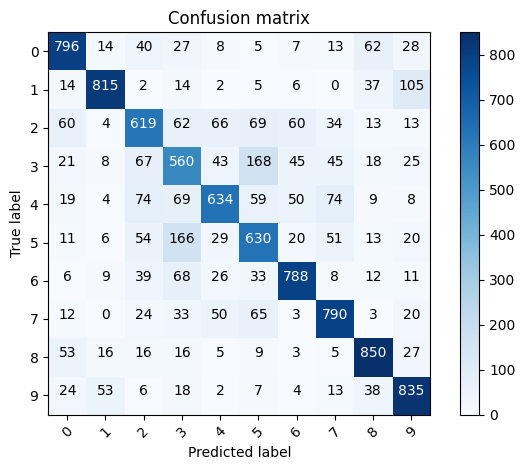

In [ ]:
# Plot the confusion matrix MODDEL 1 & 2
outputs = model1.apply(model1.params, test_images)
pred_class = jnp.argmax(outputs,1)
true_class = jnp.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
print('MODEL 1 : {}%' .format(100*acc1))
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

outputs = model2.apply(model2.params, test_images)
pred_class = jnp.argmax(outputs,1)
true_class = jnp.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
print('MODEL 2 : {}%' .format(100*acc2))
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

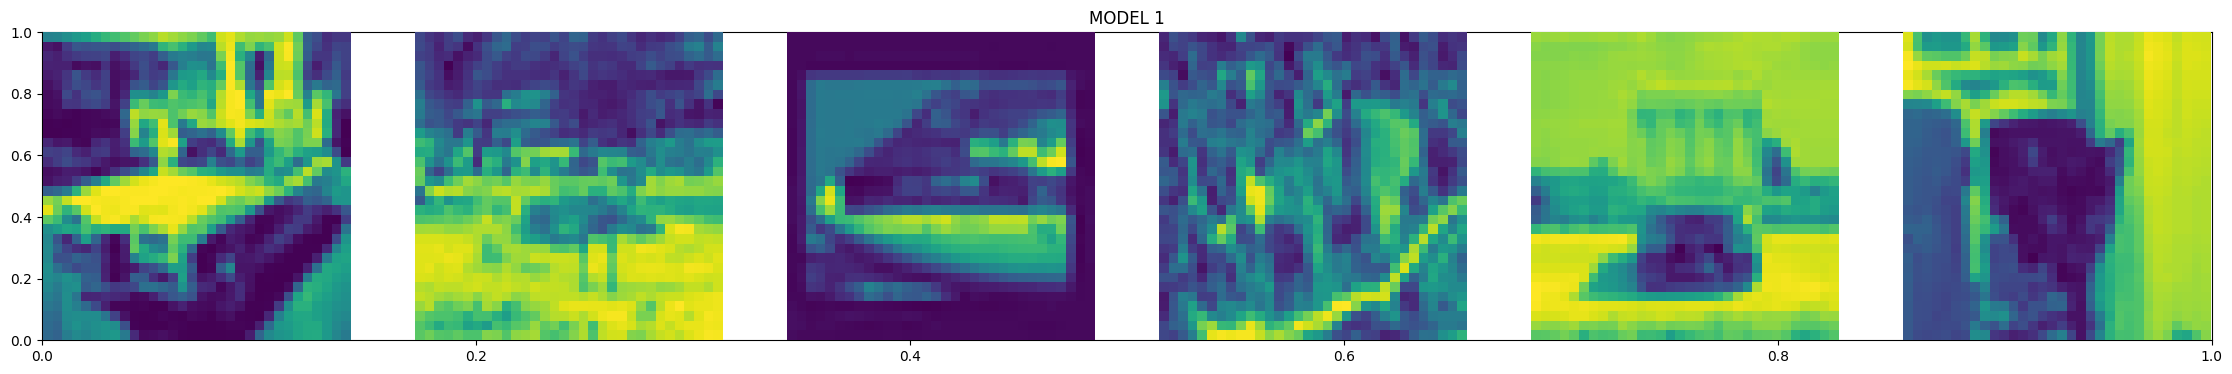

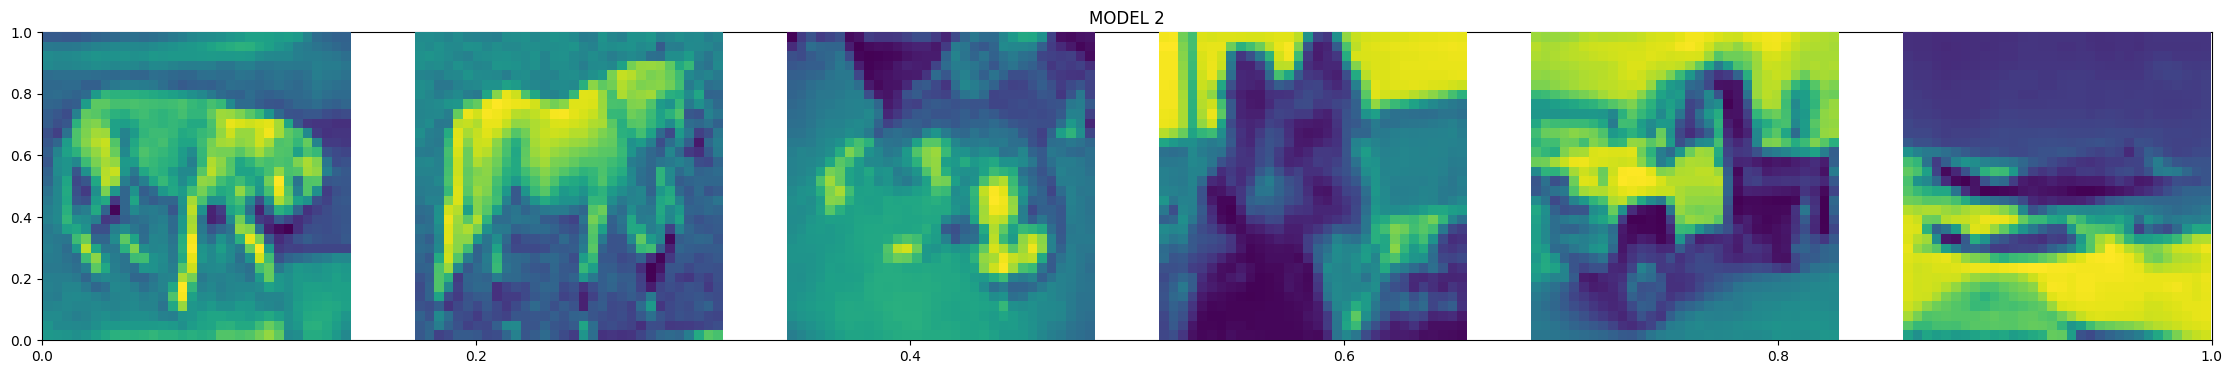

In [ ]:
# Visualize some predictions
batch = next(test_data)
images, labels = batch
plt.figure(figsize=(28,4))
plt.title('MODEL 1')
for i in range(6):
    plt.subplot(1,6,i+1)
    outputs = model1.apply(model1.params, images[i:i+1,...])
    pred_class = np.argmax(outputs,1)
    plt.imshow(images[i,:,:,0])
    plt.axis('off')


batch = next(test_data)
images, labels = batch
plt.figure(figsize=(28,4))
plt.title('MODEL 2')
for i in range(6):
    plt.subplot(1,6,i+1)
    outputs = model2.apply(model2.params, images[i:i+1,...])
    pred_class = np.argmax(outputs,1)
    plt.imshow(images[i,:,:,0])
    plt.axis('off')

### Problem 2
The [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van\_der\_Pol\_oscillator) is composed of two coupled first-order differential equations that are used to characterize many models in biological and physical sciences (e.g. as a model for action potential of neurons). The system of ODEs is given by:

$$\dot{x} = \mu (x - \frac{1}{3} x^3 - y)$$

$$\dot{y} = \frac{1}{\mu} x,$$

where $x$ is a state of the system, $y$ another state of the system, and $\dot{x}$ and $\dot{y}$ represent the evolution of the states with respect to time. The value $(\mu)$ is a parameter (constant) is a positive constant.

(i) Create a time-series data-set by using [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to integrate this system in the interval $t\in[0,50]$ using $2,000$ time-steps for $\mu = 5$ using an initial condition of $x(t=0) = 0.1$,  $y(t=0) = 0.5$. Create two plots: one for the state trajectories (the $x$-axis will represent time $t$ and the $y$-axis the system states $(x,y)$) and one for the system trajectories, so the $x$-axis will correspond to state $x$ and the $y$-axis to state $y$.

(ii) Implement a Long Short-Term Memory (LSTM) recurrent neural network with 8 lags, one hidden layer with 20 neurons, and a hyperbolic tangent activation function. Train the network using the first 2/3 of your data-set for $20,000$ stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. Use the trained model to perform **one-step-ahead predictions** until the final time $T=60$, and compare them against the true data. Plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_{2}$ norm.

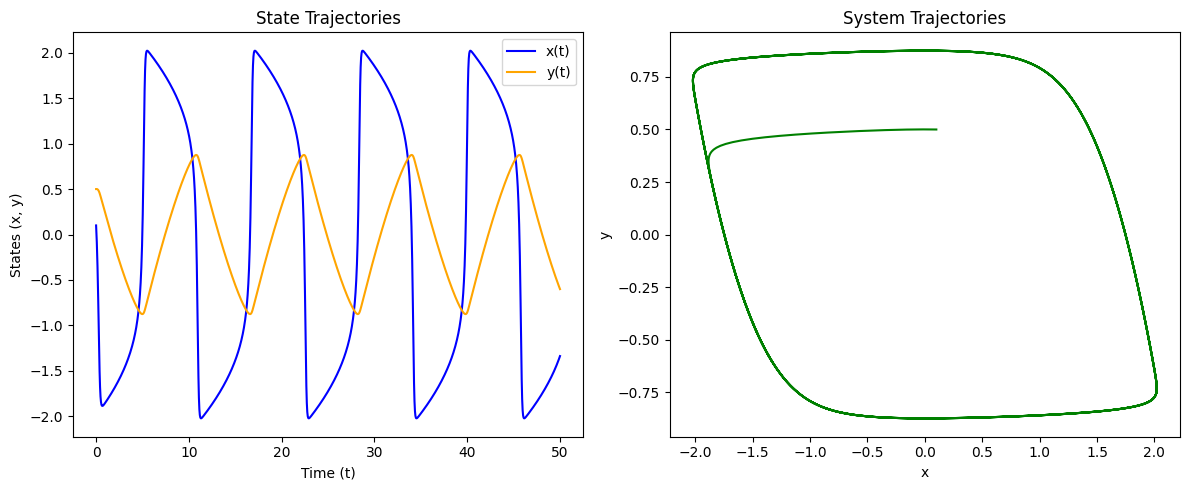

In [ ]:
import jax.numpy as np
from scipy.integrate import odeint

from jax import vmap, grad, random, jit
from jax.example_libraries import optimizers
from jax.lax import scan, fori_loop

import itertools
from functools import partial
from tqdm import trange
from matplotlib import pyplot as plt

def van_der_pol_oscillator(states, t, mu):
    x, y = states
    dxdt = mu * (x - (1/3) * x**3 - y)
    dydt = (1/mu) * x
    return [dxdt, dydt]

# Parameters and initial conditions
mu = 5.0
initial_conditions = [0.1, 0.5]
t = np.linspace(0, 50, 2000)

solution = odeint(van_der_pol_oscillator, initial_conditions, t, args=(mu,))
x, y = solution.T

# Plotting state trajectories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, x, label='x(t)', color='blue')
plt.plot(t, y, label='y(t)', color='orange')
plt.xlabel('Time (t)')
plt.ylabel('States (x, y)')
plt.title('State Trajectories')
plt.legend()

# Plotting system trajectories
plt.subplot(1, 2, 2)
plt.plot(x, y, color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.title('System Trajectories')

plt.tight_layout()
plt.show()



In [ ]:
# Helper functions for visualizing the computational graph
import jax
from jax import core
from graphviz import Digraph
import itertools

styles = {
  'const': dict(style='filled', color='goldenrod1'),
  'invar': dict(color='mediumspringgreen', style='filled'),
  'outvar': dict(style='filled,dashed', fillcolor='indianred1', color='black'),
  'op_node': dict(shape='box', color='lightskyblue', style='filled'),
  'intermediate': dict(style='filled', color='cornflowerblue')
}

def _jaxpr_graph(jaxpr):
    id_names = (f'id{id}' for id in itertools.count())
    graph = Digraph(engine='dot')
    graph.attr(size='6,10!')
    for v in jaxpr.constvars:
        graph.node(str(v), core.raise_to_shaped(v.aval).str_short(), styles['const'])
    for v in jaxpr.invars:
        graph.node(str(v), v.aval.str_short(), styles['invar'])
    for eqn in jaxpr.eqns:
        for v in eqn.invars:
            if isinstance(v, core.Literal):
                graph.node(str(id(v.val)), core.raise_to_shaped(core.get_aval(v.val)).str_short(), styles['const'])
        if eqn.primitive.multiple_results:
            id_name = next(id_names)
            graph.node(id_name, str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), id_name)
            for v in eqn.outvars:
                graph.node(str(v), v.aval.str_short(), styles['intermediate'])
                graph.edge(id_name, str(v))
        else:
            outv, = eqn.outvars
            graph.node(str(outv), str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), str(outv))
    for i, v in enumerate(jaxpr.outvars):
        outv = 'out_'+str(i)
        graph.node(outv, outv, styles['outvar'])
        graph.edge(str(v), outv)
    return graph


def jaxpr_graph(fun, *args):
    jaxpr = jax.make_jaxpr(fun)(*args).jaxpr
    return _jaxpr_graph(jaxpr)


def grad_graph(fun, *args):
    _, fun_vjp = jax.vjp(fun, *args)
    jaxpr = fun_vjp.args[0].func.args[1]
    return _jaxpr_graph(jaxpr)

In [ ]:

def LSTM(depth, dims, activation=np.tanh):
    input_dim, hidden_dim, output_dim = dims

    def init(rng_key):
        def glorot_init(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            return W

        keys = random.split(rng_key, 4)
        # Initialize weight matrices for LSTM
        Wf = glorot_init(keys[0], input_dim + hidden_dim, hidden_dim)
        bf = np.zeros(hidden_dim)
        Wi = glorot_init(keys[1], input_dim + hidden_dim, hidden_dim)
        bi = np.zeros(hidden_dim)
        Wo = glorot_init(keys[2], input_dim + hidden_dim, hidden_dim)
        bo = np.zeros(hidden_dim)
        Wc = glorot_init(keys[3], input_dim + hidden_dim, hidden_dim)
        bc = np.zeros(hidden_dim)
        # Output layer
        V = glorot_init(keys[0], hidden_dim, output_dim)
        c = np.zeros(output_dim)
        return (Wf, bf, Wi, bi, Wo, bo, Wc, bc, V, c)

    def lstm_cell(params, carry, x):
        def sigmoid(x):
          return 1 / (1 + np.exp(-x))
        Wf, bf, Wi, bi, Wo, bo, Wc, bc, _, _ = params
        h_prev, c_prev = carry
        combined = np.concatenate([x, h_prev], axis=-1)
        # LSTM gates
        fg = sigmoid(np.dot(combined, Wf) + bf)  # Forget gate
        ig = sigmoid(np.dot(combined, Wi) + bi)  # Input gate
        og = sigmoid(np.dot(combined, Wo) + bo)  # Output gate
        ct_candidate = activation(np.dot(combined, Wc) + bc)
        c = fg * c_prev + ig * ct_candidate  # Cell state
        h = og * activation(c)  # Hidden state
        return (h, c), h

    def apply(params, inputs):
        _, _, _, _, _, _, _, _, V, c = params
        init_hidden = np.zeros((inputs.shape[1], hidden_dim))
        init_cell = np.zeros((inputs.shape[1], hidden_dim))
        carry = (init_hidden, init_cell)
        carry, hidden_states = scan(partial(lstm_cell, params), carry, inputs)
        output = np.dot(hidden_states[-1], V) + c  # Final output layer
        return output

    return init, apply

In [ ]:
class Seq2Seq:
    # Initialize the class
    def __init__(self, depth, dims, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = LSTM(depth, dims)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets-outputs)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y,
                 batch_size=128,
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[:,idx,:]
        targets = Y[idx,:]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [ ]:
# Solve the Van der Pol oscillator system
mu = 5.0
initial_conditions = [0.1, 0.5]
t = np.linspace(0, 60, 2000)

solution = odeint(van_der_pol_oscillator, initial_conditions, t, args=(mu,))
x, y = solution.T

data = np.vstack((x, y)).T
# Normalize data
mu_data, std_data = data.mean(0), data.std(0)
norm_data = (data - mu_data) / std_data

In [ ]:
def create_lags(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(N):
        X = X.at[:,i,:].set(data[i:(i+lags),:])
        Y = Y.at[i,:].set(data[i+lags,:])
    return X, Y

# 8 LAGS; HIDDEN LAYERS WITH 20 NEURONS
lags = 8
train_split = int(2 * len(norm_data) / 3)
train_data, test_data = norm_data[:train_split], norm_data[train_split:]
X_train, Y_train = create_lags(train_data, lags)
X_test, Y_test = create_lags(test_data, lags)

train_data_gen = DataGenerator(X_train, Y_train)
test_data_gen = DataGenerator(X_test, Y_test)

100%|██████████| 20000/20000 [01:25<00:00, 232.88it/s, Loss=9.19419e-08]


Text(0, 0.5, 'Loss')

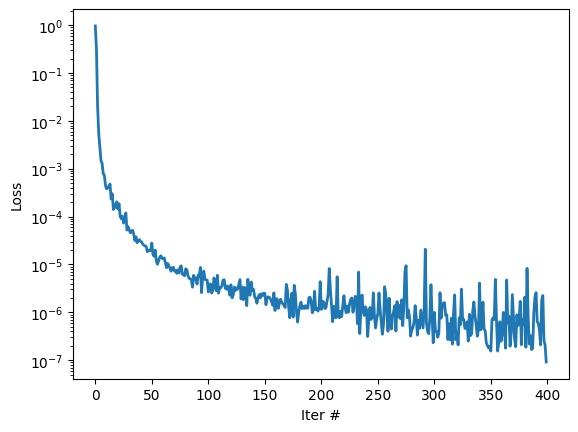

In [ ]:
# Initialize model
inp_dim = X_train.shape[-1]
out_dim = Y_train.shape[-1]
hid_dim = 20

# Train the model
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))
model.train(train_data_gen, nIter=20000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
# One-step-ahead prediction via lax.scan
def one_step_pred(inputs, step):
      outputs = model.predict(opt_params, inputs)
      inputs = inputs.at[:-1,...].set(inputs[1:,...])
      inputs = inputs.at[-1,...].set(outputs)
      return inputs, outputs[-1,:]


Relative L2 norm of prediction discrepancy: 0.10514160245656967


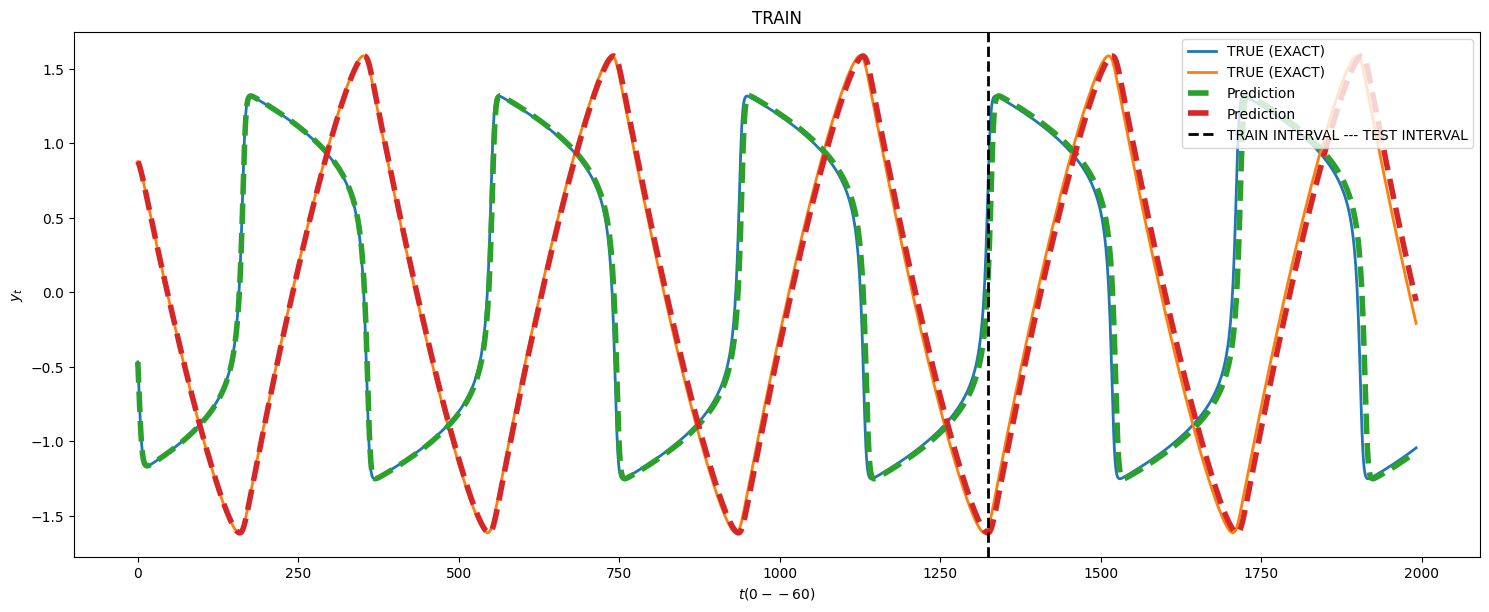

In [ ]:
steps = len(norm_data)-lags
_, predictions = scan(one_step_pred, X_train[:,0:1,:], np.arange(steps))

plt.figure(figsize=(15, 6))
plt.plot(norm_data[lags:], '-', lw = 2, label = "TRUE (EXACT)")
plt.plot(predictions, '--', lw = 4, label = "Prediction")
plt.axvline(X_train.shape[1], color='black', ls='--', lw=2, label = "TRAIN INTERVAL --- TEST INTERVAL" )
plt.xlabel('$t(0--60)$')
plt.ylabel('$y_t$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.title ("TRAIN")

rel_L2_norm = np.linalg.norm(predictions - norm_data[lags:]) / np.linalg.norm(norm_data[lags:])
print(f"Relative L2 norm of prediction discrepancy: {rel_L2_norm}")

### Problem 3
Implement a physics-informed neural network {% cite raissi2017physics1 %} to solve the Burgers' equation:

$$u_t + u u_x - \nu u_{xx} = 0, \quad \nu=0.01/\pi, \quad x\in[-1, 1], t\in[0,1],$$

$$u(0,x) = -\sin(\pi x),$$

$$u(t,-1) = u(t,1) = 0.$$

*(Hint: using 10,000 collocation points to penalize the PDE residual, 100 data-points to fit the initial conditions and 200 data-points to fit the two boundary conditions.)*

Plot your solution and report the relative $\mathbb{L}_{2}$ prediction error against the reference solution provided [here](https://github.com/PredictiveIntelligenceLab/PINNs/blob/master/appendix/Data/burgers_shock.mat).

In [ ]:
import scipy.io
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

# Define constants
nu = 0.01 / np.pi

# Define collocation points, initial, and boundary data
N_colloc, N_init, N_bc = 10000, 100, 200

# Collocation points for residual
x_colloc = random.uniform(rng_dataloader, (N_colloc, 1), minval=-1.0, maxval=1.0)
t_colloc = random.uniform(rng_dataloader, (N_colloc, 1), minval=0.0, maxval=1.0)

# Initial condition
x_init = np.linspace(-1, 1, N_init).reshape(-1, 1)
t_init = np.zeros((N_init, 1))
u_init = -np.sin(np.pi * x_init)

# Boundary condition
t_bc = np.linspace(0, 1, N_bc).reshape(-1, 1)
x_bc = np.ones((N_bc, 1))
u_bc = np.zeros((N_bc, 1))

In [ ]:
def MLP(layers, activation=np.tanh):
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [ ]:

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [ ]:
class PINNBurgers:
    # Initialize the class
    def __init__(self, layers, rng_key):
        # MLP init and apply functions
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-5, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def net_u(self, params, xt):
        return self.net_apply(params, xt)

    def net_f(self, params, xt):
        u = self.net_u(params, xt)

        u_x = grad(lambda xt: self.net_u(params, xt)[0])(xt)
        u_t = grad(lambda xt: self.net_u(params, xt)[1])(xt)

        u_xx = grad(lambda xt: u_x[0])(xt)

        f = u_t + u * u_x - nu * u_xx
        return f

    def loss(self, params, batch):
        x_colloc, t_colloc, x_init, t_init, u_init, x_bc, t_bc, u_bc = batch

        # Collocation loss
        xt_colloc = np.hstack([x_colloc, t_colloc])
        f_pred = vmap(lambda xt: self.net_f(params, xt))(xt_colloc)
        loss_colloc = np.mean(f_pred**2)

        # Initial condition loss
        xt_init = np.hstack([x_init, t_init])
        u_init_pred = vmap(lambda xt: self.net_u(params, xt))(xt_init)
        loss_init = np.mean((u_init_pred - u_init)**2)

        # Boundary condition loss
        xt_bc_left = np.hstack([-x_bc, t_bc])
        xt_bc_right = np.hstack([x_bc, t_bc])

        u_bc_pred_left = vmap(lambda xt: self.net_u(params, xt))(xt_bc_left)
        u_bc_pred_right = vmap(lambda xt: self.net_u(params, xt))(xt_bc_right)

        loss_bc = np.mean((u_bc_pred_left - u_bc)**2) + np.mean((u_bc_pred_right - u_bc)**2)

        # Total loss
        return loss_colloc + loss_init + loss_bc

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, nIter = 10000):
        batch = (x_colloc, t_colloc, x_init, t_init, u_init, x_bc, t_bc, u_bc)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, x_star, t_star):
        params = self.get_params(self.opt_state)
        xt_star = np.hstack([x_star, t_star])
        u_pred = vmap(lambda xt: self.net_u(params, xt))(xt_star)
        return u_pred

In [ ]:
layers = [2, 1024, 1024, 1]
model = PINNBurgers(layers, rng_key=rng_model)

In [ ]:
model.train(nIter=50000)

100%|██████████| 50000/50000 [1:12:23<00:00, 11.51it/s, Loss=7.9714475e-05]


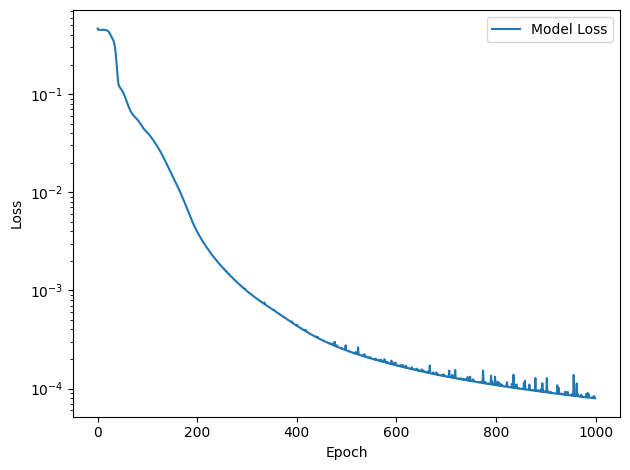

In [ ]:
# Evaluation and plotting
plt.figure()
plt.plot(np.array(model.loss_log), label="Model Loss")
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load the data
data = scipy.io.loadmat("burgers_shock.mat")
x_ref = data['x'].flatten()[:, None]
t_ref = data['t'].flatten()[:, None]
u_ref = data['usol']

x_star, t_star = np.meshgrid(x_ref.flatten(), t_ref.flatten())
x_star_flat = x_star.flatten()[:, None]
t_star_flat = t_star.flatten()[:, None]

u_pred_flat = model.predict(x_star_flat, t_star_flat)
u_pred = u_pred_flat.reshape(len(t_ref), len(x_ref)).T

# Compute the L2 error
error_l2 = np.linalg.norm(u_pred - u_ref) / np.linalg.norm(u_ref)
print("Relative L2 Error: %e" % error_l2)


Relative L2 Error: 8.589345e-01


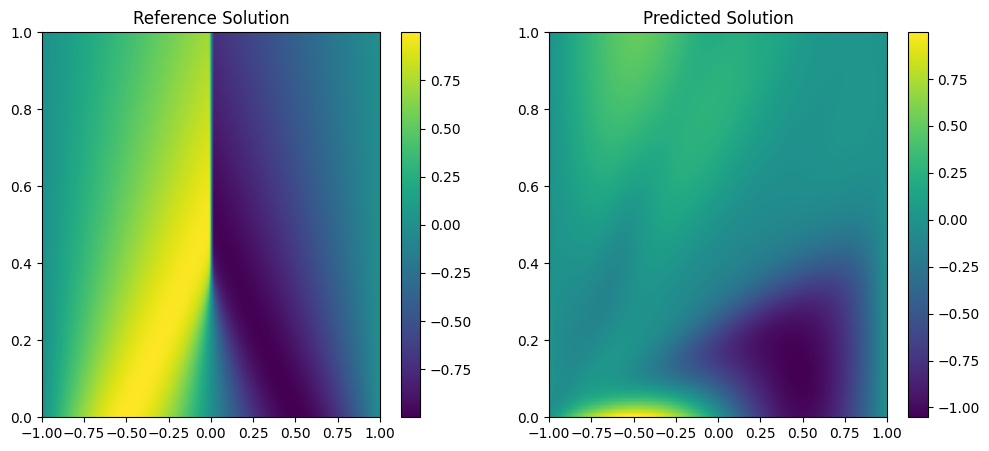

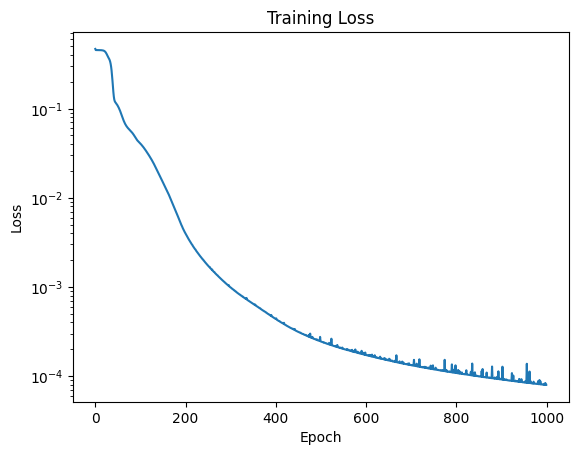

In [ ]:
# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(u_ref.T, extent=[-1,1,0,1], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Reference Solution')

plt.subplot(1,2,2)
plt.imshow(u_pred.T, extent=[-1,1,0,1], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Predicted Solution')
plt.show()

plt.figure()
plt.plot(np.array(model.loss_log))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Problem 4 [20 Points]:

Deep learning has great potential at making in-roads with traditional scientific and engineering research. In this question, we'll consider one good example of this where we'll be performing some predictions working with the [Higgs Dataset](http://mlphysics.ics.uci.edu/data/higgs/) which has been generated from Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. Note that this dataset consists of 11 million datapoints. We'll be using a subset of these for training as described below.

Our classification task is that given the 28 features, we want to predict whether the observation is a "signal" (class 1) or the background (class 0). Perform an 80:20 split of the data into training and testing. Before passing your inputs to the model, normalize your inputs to have zero mean and unit variance.

Build a model using ReLU for activation and glorot-normal initialization. Use binary cross entropy as the loss function, and perform the optimization using the Adam optimizer with default settings. Train your model till you observe a convergence of the loss curves. Plot curves showing evolution of the loss and accuracy when evaluated over the training and the testing data. Consider a 2 layer MLP of width 64.

- Consider your dataset to be randomly selected 1100 data-points from the main dataset. Perform the train / test split on this subset and use these for training your model. What do you observe in this case?
- Consider your dataset to be randomly selected 110000 data-points from the main dataset. Again, perform the train / test split on this subset and use these for training your model. Do your results differ from the earlier case?
- One way to quantify overfitting is by understanding how sensitive the function is to input noise. For any function f(x), we have that the sensitivity can be computed as

$$\int \left(\frac{df}{dx}\right)^2 p(x) dx = \mathbb{E}((f')^2)$$

This can be estimated by adding some small noise $$w$$ to the input $$x$$. For a small enough noise, we have that:

$$f(x + w) \approx f(x) + \frac{df}{dx} w$$

We can choose the noise to be drawn from a normal distribution with mean 0 and variance $$\sigma^2(w)$$. The variance of $$f(x + w)$$ is given by:

$$\sigma^2(f(x + w)) = \sigma^2(f(x) + f'(x)w) = \sigma^2(f) + \sigma^2(w) \mathbb{E}((f')^2)$$

Using this strategy, estimate the sensitivity of the 2 models you trained earlier. Note that you need to estimate over several trials and take the average. Is it consistent with your findings?

In [1]:
import jax
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers
import flax.linen as nn

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
# Modified MLP model for classification
def MLP(layers, activation=nn.relu):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return nn.sigmoid(outputs)  # For binary classification output

    return init, apply

In [3]:

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [4]:
@jit
def binary_cross_entropy_loss(logits, targets):
    return np.mean(-targets * np.log(logits + 1e-10) - (1 - targets) * np.log(1 - logits + 1e-10))

In [5]:
# Modified MLP class for binary classification
class MLPbin:
    def __init__(self, layers, rng_key):
        self.net_init, self.net_apply = MLP(layers, activation=nn.relu)
        params = self.net_init(rng_key)

        lr = optimizers.exponential_decay(1e-5, decay_steps=1000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        self.loss_log = []
        self.acc_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        logits = self.net_apply(params, inputs)
        logits = 1 / (1 + np.exp(-logits))  # Sigmoid for binary probability
        return binary_cross_entropy_loss(logits, targets)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        logits = self.net_apply(params, inputs)
        return 1 / (1 + np.exp(-logits))  # Sigmoid for probabilities

In [6]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, batch_size=128, rng_key=random.PRNGKey(123)):
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx]
        return inputs, targets

    def __getitem__(self, index):
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey, self.X, self.Y)
        return inputs, targets

In [7]:
dataset = onp.loadtxt("HIGGS.csv", delimiter=",")
X = dataset[:, 1:29]  # Features
Y = dataset[:, 0]     # Labels

# Select subsets
X_1 = X[:1100]
Y_1 = Y[:1100]
X_2 = X[:110000]
Y_2 = Y[:110000]

# Normalize
mu_X1, sigma_X1 = X_1.mean(0), X_1.std(0)
X_1 = (X_1 - mu_X1) / sigma_X1
mu_X2, sigma_X2 = X_2.mean(0), X_2.std(0)
X_2 = (X_2 - mu_X2) / sigma_X2

# Split data
train_X_1, test_X_1 = X_1[:880], X_1[880:]
train_Y_1, test_Y_1 = Y_1[:880], Y_1[880:]
train_X_2, test_X_2 = X_2[:88000], X_2[88000:]
train_Y_2, test_Y_2 = Y_2[:88000], Y_2[88000:]

# Initialize data
train_dataset_1 = DataGenerator(train_X_1, train_Y_1, batch_size=20)
train_dataset_2 = DataGenerator(train_X_2, train_Y_2, batch_size=20)

In [8]:
# Define the MLP model and train
model_1 = MLPbin(layers=[28, 64, 64, 1], rng_key=random.PRNGKey(0))
model_1.train(train_dataset_1, nIter=50000)

model_2 = MLPbin(layers=[28, 64, 64, 1], rng_key=random.PRNGKey(0))
model_2.train(train_dataset_2, nIter=50000)

100%|██████████| 50000/50000 [49:26<00:00, 16.85it/s, Loss=0.68891203]  


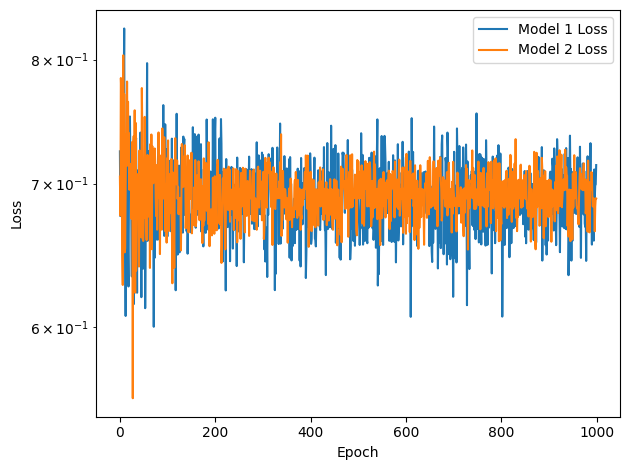

In [9]:
# Evaluation and plotting
plt.figure()
plt.plot(np.array(model_1.loss_log), label="Model 1 Loss")
plt.plot(np.array(model_2.loss_log), label="Model 2 Loss")
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:

def estimate_sensitivity(opt_params, model, X_test, noise_std=0.01, num_trials=500):
    sensitivities = []

    for _ in range(num_trials):
        noise = noise_std * random.normal(random.PRNGKey(onp.random.randint(1e5)), X_test.shape)
        X_test_noisy = X_test + noise
        # noisy input
        Y_pred_noisy = model.predict(opt_params, X_test_noisy)
        # original input
        Y_pred_original = model.predict(opt_params, X_test)

        sensitivity = np.mean((Y_pred_noisy - Y_pred_original)**2) / noise_std**2
        sensitivities.append(sensitivity)
        print(sensitivity, end='\t')

    # average sensitivity
    avg_sensitivity = np.mean(np.array(sensitivities))
    return avg_sensitivity


In [11]:
num_trials = 500
print("Sensitivity for Model 1:")
avg_sensitivity_model_1 = estimate_sensitivity(model_1.get_params(model_1.opt_state), model_1, X_1, noise_std=1, num_trials=num_trials)
print()
print("Sensitivity for Model 2:")
avg_sensitivity_model_2 = estimate_sensitivity(model_2.get_params(model_2.opt_state), model_2, X_2, noise_std=1, num_trials=num_trials)
print()
print(f"Average Sensitivity for Model 1: {avg_sensitivity_model_1:.8f}")
print()
print(f"Average Sensitivity for Model 2: {avg_sensitivity_model_2:.8f}")

Sensitivity for Model 1:
0.00055101403	0.00056814094	0.00056735164	0.00053585425	0.00055628153	0.00058328913	0.00055608427	0.000574649	0.00055449584	0.00056764827	0.0005691485	0.0005552885	0.00058042264	0.00055784464	0.000568389	0.00055024726	0.00053159986	0.00056950323	0.0005482044	0.0005556195	0.00053428445	0.00057198456	0.00055155106	0.0005758524	0.0005809832	0.0005384117	0.0005650241	0.0005690762	0.0005753663	0.00057133526	0.0005442333	0.00053732755	0.0005422614	0.00052207557	0.00055356295	0.00056116324	0.0005344251	0.00059241586	0.00052880216	0.0005695993	0.00054964575	0.000539384	0.00055583374	0.0005591374	0.0005168346	0.00052731455	0.00054688647	0.0005969006	0.000554393	0.00056971255	0.0005781434	0.00058643275	0.0005776315	0.0005780494	0.00054695405	0.00055789016	0.00054538215	0.0005691621	0.0005568008	0.0005513826	0.0005454967	0.00057429285	0.0005550698	0.0005744906	0.00054973725	0.0005617267	0.0005715697	0.0005609055	0.00056781044	0.000569858	0.0005373997	0.00055380864	0.00056

### Problem 5
Submit a two-page summary of your proposed final project. Make sure you clearly articulate the following:

- An overview of the proposed problem and why it is important.
- What are the challenges to be addressed.
- What is the current state-of-the-art and which are its potential limitations.
- What is the formal mathematical definition of the problem, and what is the technical approach you will employ.
- What is the potential impact upon the successful completion of the project.

Any figures or references should be included within the 2-page limit.

## Physics Informed learning based model predictive control for autonomous vehicle.

Proposed By : Kartik Virmani

### Overview
Off-road navigation on vertically challenging terrain, involving steep slopes and rugged boulders, presents significant challenges for autonomous vehicles both at the planning level to achieve smooth collision-free trajectories and at the control level to avoid rolling over or getting stuck. Using physics-informed reinforcement learning to adapt vehicle control for various terrain types (e.g., off-road conditions, snow, mud) where traditional control methods struggle. Physics-informed reinforcement learning (RL) integrates physical models into RL frameworks, combining model-based predictions with data-driven adaptability. This hybrid approach aims to improve control and stability across difficult terrains by leveraging physical insights to constrain and guide the RL learning process.

### Challenges

1. Complex and nonlinear dynamics, including varying levels of traction, resistance, and uneven surfaces, making it difficult for standard RL approaches to generalize without extensive training data.

2. Control systems need to adapt quickly to changing terrains. Maintaining a balance between fast real-time adaptation and stable control, especially during sharp maneuvering that are more prone to instability.


### Current state of the art and Limitations
 
 Latest control schemes all implement model predictive control but these type of policies have a huge constraint that the system is convex, furthermore advanced RL has shown potential in adapting to high-dimensional control tasks, but it often requires substantial data and lacks physical constraints, making it challenging to ensure stable and safe behavior. Despite progress in classical planning and control methods for off-road navigation, significant challenges persist. A primary challenge is accurately modeling vehicle-terrain interactions, which vary widely and are often unpredictable, particularly in vertically demanding environments. High-precision kinodynamic or vehicle-terrain interaction models integrated into sampling-based motion planners can be computationally intensive for onboard processing in mobile robots. Additionally, errors within these models may propagate through the planning and control pipeline, resulting in suboptimal performance. Moreover, the integration of multiple sensors and control algorithms adds to system complexity, making it difficult to generalize and scale across diverse terrains and applications. Learning from a high-precision physics model in a simulator with RL in advance can also alleviate onboard computation during deployment.

### Mathematical Definition and Technical approach


### Potential Impact

Physics-informed RL would enable autonomous vehicles to handle off-road conditions with confidence, allowing their use in environments traditionally unsuitable for rigidly controlled vehicles. This framework could extend beyond vehicles and quadrupeds to other autonomous systems that require terrain adaptation, such as drones navigating forest canopies or manipulators interacting with unpredictable objects. By guiding exploration with physical constraints, the approach would reduce training data requirements, potentially enabling faster deployment of autonomous systems.


